# PSF Experiment Notebook

This notebook contains the basic PSF test

2. Can AutoMetaCal perform better than ngmix by using the input PSFs for reconv? Using the PSF response...


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tqdm

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf
import galsim
import ngmix

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Test setup

In [3]:
#global values
fixnoise = True
batch_size=1000
scale= .2
stamp_size = 51
rng = np.random.RandomState(31415)
real_shear = [0.01,0.0]
noise_level = 1e-4

### Data

In [4]:
#dataset
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

Display a range of galaxy models:

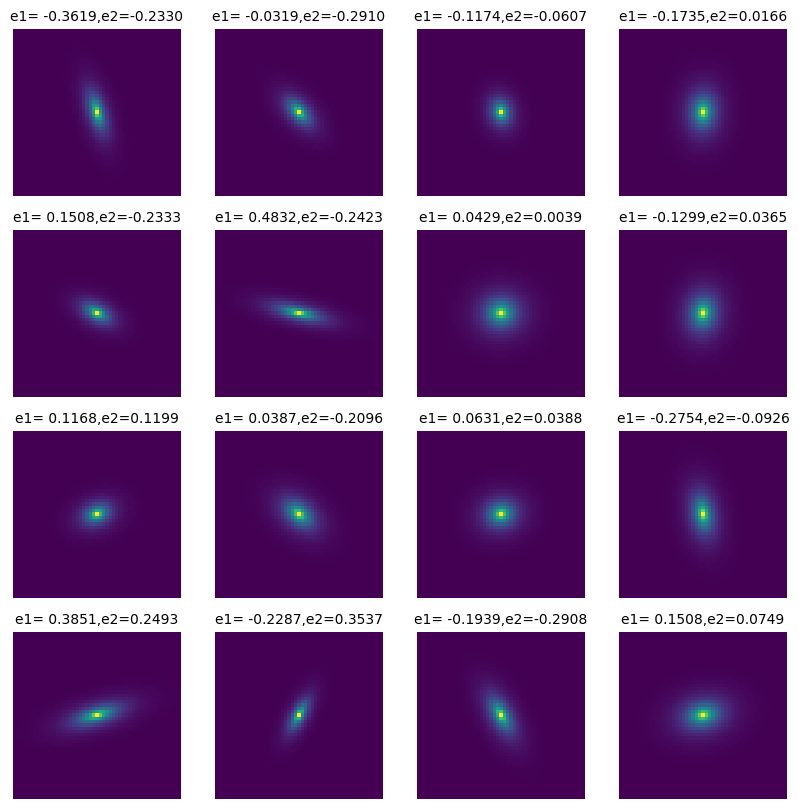

In [5]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

We transform these models by:
1. Adding a constant shear
3. Convolving with a PSF
2. Adding some noise

Both 1 and 2 are taken care by the noiseless_real_mcal_image function developed for the LearnR project.

In [6]:
#create 1 batch of observed images


psf_fwhm = 0.7
psf = galsim.Moffat(beta=5.0, fwhm=psf_fwhm).shear(g1=.0,g2=0.)
psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
psf_images = tf.repeat(psf_image,1000,axis=0)



gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([real_shear],
                                        len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[batch_size,51,51])
gal_images += noise
psf_images = onebatch['psf_image']

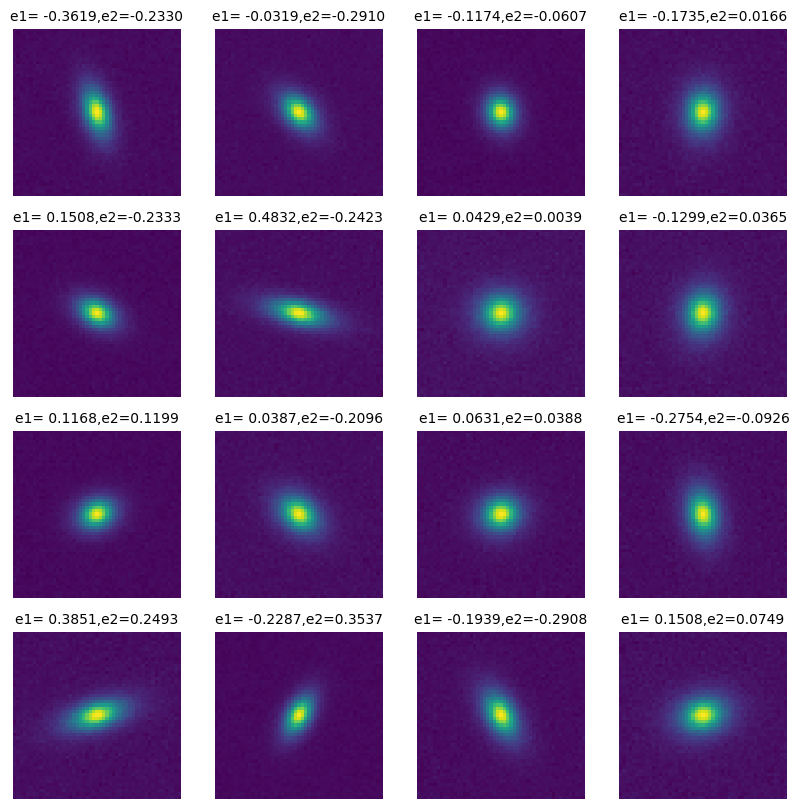

In [7]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin= 'lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

## Set up ngmix

In [8]:
#set up jacobian
jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

In [9]:
# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements

types = ['noshear', '1p', '1m','2p','2m']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=fixnoise,
)

Set up functions to get responses from AMC and ngmix

In [10]:
#for ngmix
def get_metacal_response_ngmix(resdict):
  step=0.01

  e1, e2 = resdict['noshear']['e1'], resdict['noshear']['e2']
 
  g0s = np.array([resdict['noshear']['e1'], resdict['noshear']['e2']])
  g1p = np.array([resdict['1p']['e1'], resdict['1p']['e2']])
  g1m = np.array([resdict['1m']['e1'], resdict['1m']['e2']])
  g2p = np.array([resdict['2p']['e1'], resdict['2p']['e2']])
  g2m = np.array([resdict['2m']['e1'], resdict['2m']['e2']])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)  
   
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
    
  return ellip_dict, R 

In [11]:
def generate_mcal_image(gal_images,
                        psf_images,
                        reconvolution_psf_image,
                        g, gp,
                        padfactor=3):
  """ Generate a metacalibrated image given input and target PSFs.
  
  Args: 
    gal_images: tf.Tensor or np.array
      (batch_size, N, N ) image of galaxies
    psf_images: tf.Tensor or np.array
      (batch_size, N, N ) image of psf model
    reconvolution_psf_image: tf.Tensor
      (N, N ) tensor of reconvolution psf model
    g: tf.Tensor or np.array
    [batch_size, 2] input shear
  Returns:
    img: tf.Tensor
      tf tensor containing image of galaxy after deconvolution by psf_deconv, 
      shearing by g, and reconvolution with reconvolution_psf_image.
  
  """
  #cast stuff as float32 tensors
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)  
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)  
  reconvolution_psf_image = tf.convert_to_tensor(reconvolution_psf_image, dtype=tf.float32)  
  g = tf.convert_to_tensor(g, dtype=tf.float32)  
  
  #Get batch info
  batch_size, nx, ny = gal_images.get_shape().as_list()  
      
  #add pads in real space
  fact = (padfactor - 1)//2 #how many image sizes to one direction
  paddings = tf.constant([[0, 0,], [nx*fact, nx*fact], [ny*fact, ny*fact]])
    
  padded_gal_images = tf.pad(gal_images,paddings)
  padded_psf_images = tf.pad(psf_images,paddings)
  padded_reconvolution_psf_image = tf.pad(reconvolution_psf_image,paddings)
    
  #Convert galaxy images to k space
  im_shift = tf.signal.ifftshift(padded_gal_images,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, tf.complex64)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  
  #Convert psf images to k space  
  psf_complex = tf.cast(padded_psf_images, tf.complex64)
  psf_fft = tf.signal.fft2d(psf_complex)
  psf_fft_abs = tf.abs(psf_fft)
  psf_fft_abs_complex = tf.cast(psf_fft_abs,tf.complex64)
  kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  #Convert reconvolution psf image to k space 
  rpsf_complex = tf.cast(padded_reconvolution_psf_image, tf.complex64)
  rpsf_fft =  tf.signal.fft2d(rpsf_complex)
  rpsf_fft_abs = tf.abs(rpsf_fft)
  psf_fft_abs_complex = tf.cast(rpsf_fft_abs,tf.complex64)
  krpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  # Compute Fourier mask for high frequencies
  # careful, this is not exactly the correct formula for fftfreq
  kx, ky = tf.meshgrid(tf.linspace(-0.5,0.5,padfactor*nx),
                       tf.linspace(-0.5,0.5,padfactor*ny))
  mask = tf.cast(tf.math.sqrt(kx**2 + ky**2) <= 0.5, dtype='complex64')
  mask = tf.expand_dims(mask, axis=0)
  
  # Deconvolve image from input PSF
  im_deconv = imk * ( (1./(kpsf+1e-10))*mask)

  # Apply shear to the  deconv image
  im_sheared = gf.shear(tf.expand_dims(im_deconv,-1), g[...,0], g[...,1])[...,0]  

  # Apply shear to the  kpsf image
  kpsf_sheared = gf.shear(tf.expand_dims(kspsf,-1), gp[...,0], gp[...,1])[...,0]    
  
  # Reconvolve with target PSF
  im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared * kpsf_sheared * mask))

  # Compute inverse Fourier transform
  img = tf.math.real(tf.signal.fftshift(im_reconv))
  return img[:,fact*nx:-fact*nx,fact*ny:-fact*ny]

In [12]:
def get_metacal_response(gal_images,
                         psf_images,
                         reconvolution_psf_image,
                         method):
  """
  Convenience function to compute the shear response
  """  
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  gs = tf.zeros([batch_size, 4])

  with tf.GradientTape() as tape:
    tape.watch(gs)
    # Measure ellipticity under metacal
    e = method(generate_mcal_image(gal_images,
                                   psf_images,
                                   psf_images,
                                   gs[:,0:2],gs[:,2:4]))
    epsf = method(psf_images)
  # Compute response matrix

  Rs = tape.batch_jacobian(e, gs)
  R, Rpsf = Rs[...,0:2], Rs[...,2:4]
  return e, epsf, R, Rpsf

In [13]:
#AutoMetaCal runner
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)

#for amc
@tf.function
def response(gal_images,psf_images):
  return get_metacal_response(gal_images, psf_images,psf_images,method)

## Shakedown Test!

Let's make a measurement on a single image.

In [14]:
im = gal_images[0]
psf_im = psf_images[0] 

In [15]:
wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

Run one ngmix measurement:

In [16]:
resdict, obsdict = boot.go(obs)

In [17]:
true = labels[0]

#ngmix calibration
ellips, R_ngmix = get_metacal_response_ngmix(resdict)
calibrated_ngmix = linalg.inv(R_ngmix) @ ellips['noshear']

e_amc, e_psf, R_auto, R_psf = response(im[tf.newaxis], psf_im[tf.newaxis])
calibrated_amc = linalg.inv(R_auto[0].numpy()) @ e_amc[0].numpy()

In [18]:
print("True:")
print(f"e1={true[0]:.6f}, e2={true[1]:.6f}.")

print("\nngmix:")
print(f"e1={calibrated_ngmix[0]:.6f}, e2={calibrated_ngmix[1]:.6f}.")

print("\nAutoMetaCal")
print(f"e1={calibrated_amc[0]:.6f}, e2={calibrated_amc[1]:.6f}.")

True:
e1=-0.361909, e2=-0.233026.

ngmix:
e1=-0.396083, e2=-0.266887.

AutoMetaCal
e1=-0.396140, e2=-0.266886.


## One Batch Test

In [19]:
#reset data
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

In [20]:
#get response and noshear ellipticities
e_amc, e_psf, R_auto, R_psf = response(gal_images, psf_images)
e_amc=tf.concat([e_amc],axis=0)
R_auto=tf.concat([R_auto],axis=0)

#averaging procedure
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0)
calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(batch_size)

Testing AMC speed: 

In [21]:
%%timeit
e_amc_batch, e_psf_batch, R_auto_batch, R_psf_batch = response(gal_images, psf_images)

5.41 s ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


To be fair, let's use ngmix in parallel. 

In [22]:
#parallelisable function to map the data to
def response_ngmix(im_psf):
  im, psf = im_psf
  
  psf_obs = ngmix.Observation(
    psf_im,
    weight=psf_wt,
    jacobian=psf_jacobian,
  )
  obs = ngmix.Observation(
    im,
    jacobian=jacobian,
    weight=wt,
    psf=psf_obs,
  )
  
  #get moment ellipticities
  resdict, obsdict = boot.go(obs)
  e_ngmix, R_ngmix = get_metacal_response_ngmix(resdict)
  
  return e_ngmix['noshear'], R_ngmix

In [23]:
from multiprocessing import Pool, freeze_support, cpu_count
pool = Pool(cpu_count()) 

In [24]:
gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
psf_imlist = [psf_images[i] for i in range(len(gal_images))]
ims_psfs = zip(gal_imlist,psf_imlist)

Testing ngmix speed:

In [25]:
t = time.time()
results = pool.map(response_ngmix, ims_psfs)
print(f"Finished in: {time.time()-t} s.")

Finished in: 5.081081867218018 s.


In [26]:
pool.close()

In [27]:
e_ngmix_list = [result[0] for result in results]
R_ngmix_list = [result[1] for result in results]

In [28]:
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size)

In [29]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

print("\nngmix shear estimation over 1k")
print(f"e1={calibrated_shear_ngmix[0]:.6f}, e2={calibrated_shear_ngmix[1]:.6f}.")

True:
e1=0.010000, e2=0.000000.

Uncalibrated shear estimation over 1k
e1=0.004153, e2=0.002623.

AutoMetaCal shear estimation over 1k
e1=0.009389, e2=0.005928.

ngmix shear estimation over 1k
e1=0.009389, e2=0.005931.


In [30]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] - 1 
m1_amc_err =  calibrated_shear_amc_err[0,0]/real_shear[0]
print("Autometacal:")
print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
m1_ngmix_err =  calibrated_shear_ngmix_err[0]/real_shear[0] 
print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f} +/- {m1_ngmix_err: .6f}")

Autometacal:
m_1 = -0.061053 +/-  0.748383

ngmix:
m_1 = -0.061071 +/-  0.748484


In [1]:
banana();

NameError: name 'banana' is not defined

## All Batches Test

In [40]:
#reset data
batchit = data.as_numpy_iterator()

e_amc = []
e_psf = []
R_auto = []
R_psf = []
e_ngmix_list = []
R_ngmix_list = []

psf_fwhm = 0.7
psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm).shear(g1=.01,g2=0.)
psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
psf_images = tf.repeat(psf_image,1000,axis=0).numpy()

for _ in tqdm.tqdm(range(100)):
  onebatch = batchit.next()
  
  #prepare batch
  gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],psf_images,#onebatch['psf_image'],
                            tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

  noise = np.random.normal(scale=noise_level,size=[len(gal_images),51,51])
  
  gal_images += noise
  #psf_images += noise/100

  #run amc
  e_amc_batch, e_psf_batch, R_auto_batch, R_psf_batch = response(gal_images, psf_images)
  #gather amc results
  e_amc.append(e_amc_batch)
  e_psf.append(e_psf_batch)
  R_auto.append(R_auto_batch)
  R_psf.append(R_psf_batch)

  
  #prepare list for parallel map
  gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
  psf_imlist = [psf_images[i] for i in range(len(gal_images))]
  ims_psfs = zip(gal_imlist,psf_imlist)
  
  #start and run parallel pool
  pool = Pool(cpu_count()//2)
  results = pool.map(response_ngmix, ims_psfs)
  pool.close()
  
  #append ngmix results
  e_ngmix_list += [result[0] for result in results]
  R_ngmix_list += [result[1] for result in results]  
  
e_amc=tf.concat(e_amc,axis=0)
e_psf = tf.concat(e_psf,axis=0)
R_auto=tf.concat(R_auto,axis=0)
R_psf=tf.concat(R_psf,axis=0)

100%|██████████| 100/100 [32:34<00:00, 19.54s/it]


In [32]:
#averaging amc results
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0) 

remove_psf =tf.reduce_mean(R_psf[:],axis=0) @  tf.reduce_mean(tf.reshape(e_psf,[-1,2,1]),axis=0)

calibrated_shear_amc -= remove_psf

calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(batch_size*100)

#averaging ngmix results
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size*100)

In [33]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] -1 
m1_amc_err = calibrated_shear_amc_err[0,0]/real_shear[0]

print("Autometacal:")
print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
m1_ngmix_err = calibrated_shear_ngmix_err[0]/real_shear[0]

print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f} +/- {m1_ngmix_err: .6f}")

Autometacal:
m_1 =  0.053452 +/-  0.077445

ngmix:
m_1 =  0.039861 +/-  0.076453


## Varying the PSF test

In this test we will progressively shear the psf and observe how the residual m changes.

In [34]:
def loop(psf_images):
  e_amc = []
  e_psf = []
  R_auto = []
  R_psf = []
  e_ngmix_list = []
  R_ngmix_list = []
  for _ in tqdm.tqdm(range(100)):
    onebatch = batchit.next()

    #prepare batch
    gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                             psf_images, #real psfs are noiseless
                                             tf.repeat([real_shear],len(onebatch['gal_model']),axis=0)
                                            )

    noise = np.random.normal(scale=noise_level,size=[len(gal_images),51,51])

    gal_images += noise
    psf_images += noise/100 #observed psfs have some noise

    #run amc
    e_amc_batch, e_psf_batch, R_auto_batch, R_psf_batch = response(gal_images, psf_images)
    #gather amc results
    e_amc.append(e_amc_batch)
    e_psf.append(e_psf_batch)
    R_auto.append(R_auto_batch)
    R_psf.append(R_psf_batch)


    #prepare list for parallel map
    gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
    psf_imlist = [psf_images[i] for i in range(len(gal_images))]
    ims_psfs = zip(gal_imlist,psf_imlist)

    #start and run parallel pool
    pool = Pool(cpu_count())
    results = pool.map(response_ngmix, ims_psfs)
    pool.close()

    #append ngmix results
    e_ngmix_list += [result[0] for result in results]
    R_ngmix_list += [result[1] for result in results]  

  e_amc=tf.concat(e_amc,axis=0)
  e_psf = tf.concat(e_psf,axis=0)
  R_auto=tf.concat(R_auto,axis=0)
  R_psf=tf.concat(R_psf,axis=0)
  #averaging amc results
  uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
  calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0) 

  remove_psf = tf.linalg.inv(tf.reduce_mean(R_psf[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_psf,[-1,2,1]),axis=0)

  calibrated_shear_amc -= remove_psf


  calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(batch_size*100)

  #averaging ngmix results
  calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
  calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size*100)
  
  
  m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] -1 
  m1_amc_err = calibrated_shear_amc_err[0,0]/real_shear[0]

  print("Autometacal:")
  print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

  m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
  m1_ngmix_err = calibrated_shear_ngmix_err[0]/real_shear[0]

  print("\nngmix:")
  print(f"m_1 = {m1_ngmix: .6f} +/- {m1_ngmix_err: .6f}")
  
  return m1_amc, m1_ngmix  

In [35]:
psf_shears = [0.0,.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]

In [ ]:
residual_m_amc = []
residual_m_ngmix = []

for psf_shear in psf_shears:
  print(f"psf g1 = {psf_shear}")
  psf_fwhm = 0.7
  batchit = data.as_numpy_iterator()
  psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm).shear(g1=psf_shear,g2=0)
  psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
  psf_images = tf.repeat(psf_image,1000,axis=0).numpy()

  m1_amc, m1_ngmix = loop(psf_images)
  residual_m_amc.append(m1_amc)
  residual_m_ngmix.append(m1_ngmix)  

psf g1 = 0.0


 33%|███▎      | 33/100 [14:27<30:15, 27.09s/it]

In [ ]:
np.save("residual_m_amc.npy",residual_m_amc)
np.save("residual_m_ngmix.npy",residual_m_ngmix)